# Train a custom object detection, including Toradex modules, with TensorFlow Lite Model Maker

In this Jupyter notebook, you will learn how to use the **TensorFlow Lite Model Maker** to train a custom object detection model to detect Toradex modules and other basic objects.

The Model Maker library uses *transfer learning* to simpliify the training process of a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.


## Preparation

### Python version

**Warning**: This code has been tested on different versions of Python and has been verified to only works below **Python 3.9**. This was tested on **Python 3.9**.

It is recommended to use the **Conda** software to install a different version of Python and install the package **ipykernel** to run a Jupyter notebook.

### Install the required packages to training
Now, install the required packages, including the **tflite-model-maker** the **tflite-support** package.

In [1]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

Import the required packages.

In [2]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/home/lucas_bernardes/miniconda3/envs/py39_test/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/lucas_bernardes/miniconda3/envs/py39_test/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to e

### Prepare the dataset

An example dataset including a part of VOC 2012 dataset and Toradex modules was provided for example. This dataset can be download from the GitHub repository.

We start with downloading the dataset.

In [7]:
!git clone git@github.com:lucasbernardestoradex/voc_dataset.git

Cloning into 'voc_dataset'...
remote: Enumerating objects: 5062, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5062 (delta 0), reused 6 (delta 0), pack-reused 5056
Receiving objects: 100% (5062/5062), 155.22 MiB | 11.37 MiB/s, done.
Resolving deltas: 100% (2340/2340), done.


## Train the object detection model

### Step 1: Load the dataset

* Images in `train_data` is used to train the custom object detection model.
* Images in `val_data` is used to check if the model can generalize well to new images that it hasn't seen before.

In [8]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'voc_dataset/voc_som_dataset/train',
    'voc_dataset/voc_som_dataset/train',
    ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'som', 'train', 'tvmonitor']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'voc_dataset/voc_som_dataset/valid',
    'voc_dataset/voc_som_dataset/valid',
    ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'som', 'train', 'tvmonitor']
)

### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite0 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you.

In [9]:
spec = model_spec.get('efficientdet_lite0')

### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [10]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=val_data)

2024-03-18 15:39:40.305705: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


422/422 [==============================] - ETA: 0s - det_loss: 1.4269 - cls_loss: 1.0090 - box_loss: 0.0084 - reg_l2_loss: 0.0667 - loss: 1.4936 - learning_rate: 0.0065 - gradient_norm: 4.2069

2024-03-18 15:43:34.305582: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


422/422 [==============================] - 249s 560ms/step - det_loss: 1.4257 - cls_loss: 1.0080 - box_loss: 0.0084 - reg_l2_loss: 0.0667 - loss: 1.4924 - learning_rate: 0.0065 - gradient_norm: 4.2081 - val_det_loss: 1.2103 - val_cls_loss: 0.9634 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0670 - val_loss: 1.2773


### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the images in the validation dataset to evaluate how the model performs against new data it has never seen before.

The default batch size is 64.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [11]:
model.evaluate(val_data)

9/9 [==============================] - 37s 2s/step



{'AP': 0.02093394,
 'AP50': 0.04789241,
 'AP75': 0.014667888,
 'APs': 0.0023514852,
 'APm': 0.013334375,
 'APl': 0.026446434,
 'ARmax1': 0.07395685,
 'ARmax10': 0.115447916,
 'ARmax100': 0.11794272,
 'ARs': 0.003030303,
 'ARm': 0.04218439,
 'ARl': 0.13478832,
 'AP_/aeroplane': 0.039209343,
 'AP_/bicycle': 0.0,
 'AP_/bird': 7.033363e-05,
 'AP_/boat': 0.0038072234,
 'AP_/bottle': 0.0,
 'AP_/bus': 0.0006566983,
 'AP_/car': 0.10778892,
 'AP_/cat': 0.037801873,
 'AP_/chair': 0.001351921,
 'AP_/cow': 0.0,
 'AP_/diningtable': 0.00013945057,
 'AP_/dog': 0.014452348,
 'AP_/horse': 0.012095887,
 'AP_/motorbike': 0.0005521206,
 'AP_/person': 0.16393146,
 'AP_/pottedplant': 0.0,
 'AP_/sheep': 0.0,
 'AP_/sofa': 0.0055259494,
 'AP_/som': 0.018591005,
 'AP_/train': 0.0034322783,
 'AP_/tvmonitor': 0.030205887}

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on CPU.

In [12]:
model.export(export_dir='.', tflite_filename='voc_som.tflite')

2024-03-18 15:44:31.224483: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2024-03-18 15:44:43.489343: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


Estimated count of arithmetic ops: 1.823 G  ops, equivalently 0.911 G  MACs


2024-03-18 15:44:47.834520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-03-18 15:44:47.834567: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-03-18 15:44:47.851326: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpeai35awf
2024-03-18 15:44:47.910187: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-03-18 15:44:47.910223: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpeai35awf
2024-03-18 15:44:48.152043: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-03-18 15:44:49.519450: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpeai35awf
2024-03-18 15:44:50.064976: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2214093

Estimated count of arithmetic ops: 1.823 G  ops, equivalently 0.911 G  MACs


### Step 6:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [13]:
model.evaluate_tflite('voc_som.tflite', val_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


535/535 [==============================] - 602s 1s/step



{'AP': 0.013438265,
 'AP50': 0.031388354,
 'AP75': 0.009189773,
 'APs': 0.00220022,
 'APm': 0.011610389,
 'APl': 0.016435692,
 'ARmax1': 0.02157939,
 'ARmax10': 0.035414513,
 'ARmax100': 0.037065662,
 'ARs': 0.003030303,
 'ARm': 0.023940671,
 'ARl': 0.04484858,
 'AP_/aeroplane': 0.0005211047,
 'AP_/bicycle': 0.0,
 'AP_/bird': 0.0,
 'AP_/boat': 9.1393755e-05,
 'AP_/bottle': 0.0,
 'AP_/bus': 0.0,
 'AP_/car': 0.09685857,
 'AP_/cat': 0.029265787,
 'AP_/chair': 0.0,
 'AP_/cow': 0.0,
 'AP_/diningtable': 0.0,
 'AP_/dog': 0.0,
 'AP_/horse': 0.0,
 'AP_/motorbike': 0.0,
 'AP_/person': 0.15433112,
 'AP_/pottedplant': 0.0,
 'AP_/sheep': 0.0,
 'AP_/sofa': 3.493302e-05,
 'AP_/som': 0.0011006728,
 'AP_/train': 0.0,
 'AP_/tvmonitor': 0.0}

## Test the Android figurine detection model

After training the model, let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

This is a good pré-test, before trying to run the model on the Toradex SoMs.

**Load the trained TFLite model and define some visualization functions**

In [14]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

**Run object detection and show the detection results**

You can change the threshold, the input image and the model.

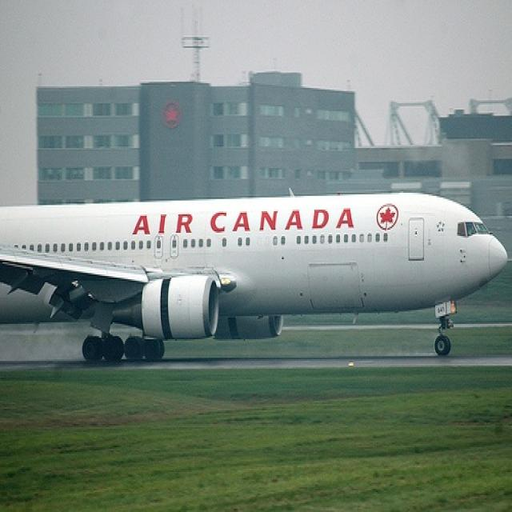

In [15]:
#@title Run object detection and show the detection results

from PIL import Image

DETECTION_THRESHOLD = 0.5 # Sensibility of detection
TFLITE_MODEL_PATH = "voc_som.tflite" # TFLite model

# Change this input_image to the desired test image. The dataset provide a lot of examples
input_image = "voc_dataset/voc_som_dataset/test/2007_000738_jpg.rf.68e7dadc4e8ad97496ef6e83775e9bc7.jpg"

image = Image.open(input_image).convert('RGB')
image.thumbnail((512, 512), Image.LANCZOS)
image_np = np.asarray(image)
image_np = image_np.astype(np.uint8) # Mandatory for some images

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)